Data could be found at: https://grouplens.org/datasets/movielens/latest/

## Part 1: Data ETL

In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType,StringType, IntegerType, FloatType
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from pyspark.sql.types import StructType, StructField
import re


In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
movies_df = spark.read.load("/FileStore/tables/movies.csv", format='csv', header = True)
ratings_df = spark.read.load("/FileStore/tables/ratings.csv", format='csv', header = True)
links_df = spark.read.load("/FileStore/tables/links.csv", format='csv', header = True)
tags_df = spark.read.load("/FileStore/tables/tags.csv", format='csv', header = True)
tmp1 = ratings_df.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings_df.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [0]:
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [0]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [0]:
links_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [0]:
tags_df.show(5)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [0]:
tmp1 = ratings_df.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings_df.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [0]:
tmp1 = sum(ratings_df.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings_df.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user


## Part 2: OLAP

In [0]:
movies_df.registerTempTable("movies")
ratings_df.registerTempTable("ratings")
links_df.registerTempTable("links")
tags_df.registerTempTable("tags")

/databricks/spark/python/pyspark/sql/dataframe.py:331: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [0]:
Num_users = spark.sql("Select Count(Distinct userId) as Number_of_Users from ratings")
Num_users.show()

+---------------+
|Number_of_Users|
+---------------+
|            610|
+---------------+



In [0]:
Num_mv = spark.sql("Select Count(movieId) as Number_of_Moives from movies")
Num_mv.show()

+----------------+
|Number_of_Moives|
+----------------+
|            9742|
+----------------+



In [0]:
Num_rt = spark.sql("Select Count(*) as Number_of_Ratings from ratings")
Num_rt.show()

+-----------------+
|Number_of_Ratings|
+-----------------+
|           100836|
+-----------------+



Out[103]: <AxesSubplot:xlabel='rating', ylabel='count'>

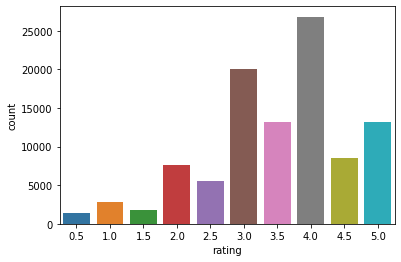

In [0]:
ratings_dis = spark.sql("Select rating, Count(*) as count from ratings group by 1 order by 1").toPandas()
sns.barplot(x="rating", y="count", data=ratings_dis)

In [0]:
Num_rated_mv = spark.sql("Select Count(movieId) as Number_of_Rated_Moives From movies Where movieID in (Select movieId From ratings)")
Num_rated_mv.show()

+----------------------+
|Number_of_Rated_Moives|
+----------------------+
|                  9724|
+----------------------+



In [0]:
unrated_list=spark.sql('SELECT * ' +\
                       'FROM movies ' +\
                       'WHERE movieId NOT IN ( ' +\
                        'SELECT movieId ' +\
                        'FROM ratings ' +\
                       ') ')
print('Movies that have not been rated by users:')
unrated_list.show()

Movies that have not been rated by users:
+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|   1076|Innocents, The (1...|Drama|Horror|Thri...|
|   2939|      Niagara (1953)|      Drama|Thriller|
|   3338|For All Mankind (...|         Documentary|
|   3456|Color of Paradise...|               Drama|
|   4194|I Know Where I'm ...|   Drama|Romance|War|
|   5721|  Chosen, The (1981)|               Drama|
|   6668|Road Home, The (W...|       Drama|Romance|
|   6849|      Scrooge (1970)|Drama|Fantasy|Mus...|
|   7020|        Proof (1991)|Comedy|Drama|Romance|
|   7792|Parallax View, Th...|            Thriller|
|   8765|This Gun for Hire...|Crime|Film-Noir|T...|
|  25855|Roaring Twenties,...|Crime|Drama|Thriller|
|  26085|Mutiny on the Bou...|Adventure|Drama|R...|
|  30892|In the Realms of ...|Animation|Documen...|
|  32160|Twentieth Century...|              Comedy|
|  32371|Call Northsid

In [0]:
genres_list = spark.sql('select genres from movies')
genres_list.show()

+--------------------+
|              genres|
+--------------------+
|Adventure|Animati...|
|Adventure|Childre...|
|      Comedy|Romance|
|Comedy|Drama|Romance|
|              Comedy|
|Action|Crime|Thri...|
|      Comedy|Romance|
|  Adventure|Children|
|              Action|
|Action|Adventure|...|
|Comedy|Drama|Romance|
|       Comedy|Horror|
|Adventure|Animati...|
|               Drama|
|Action|Adventure|...|
|         Crime|Drama|
|       Drama|Romance|
|              Comedy|
|              Comedy|
|Action|Comedy|Cri...|
+--------------------+
only showing top 20 rows



In [0]:
# Seperate different genres by udf
genre_sep = udf(lambda x: x.split('|'), ArrayType(StringType()))
spark.udf.register('genre_sep',genre_sep)
spark.sql('SELECT DISTINCT genres_list ' +\
          'FROM movies  ' +\
          'LATERAL VIEW EXPLODE(genre_sep(genres)) AS genres_list ' +\
          'ORDER BY 1').show()

+------------------+
|       genres_list|
+------------------+
|(no genres listed)|
|            Action|
|         Adventure|
|         Animation|
|          Children|
|            Comedy|
|             Crime|
|       Documentary|
|             Drama|
|           Fantasy|
|         Film-Noir|
|            Horror|
|              IMAX|
|           Musical|
|           Mystery|
|           Romance|
|            Sci-Fi|
|          Thriller|
|               War|
|           Western|
+------------------+



In [0]:
genre_method2 = spark.sql("Select Distinct explode(split(genres,'[|]')) as genres From movies Order by 1")
genre_method2.show()

+------------------+
|            genres|
+------------------+
|(no genres listed)|
|            Action|
|         Adventure|
|         Animation|
|          Children|
|            Comedy|
|             Crime|
|       Documentary|
|             Drama|
|           Fantasy|
|         Film-Noir|
|            Horror|
|              IMAX|
|           Musical|
|           Mystery|
|           Romance|
|            Sci-Fi|
|          Thriller|
|               War|
|           Western|
+------------------+



In [0]:
Num_mv_cat = spark.sql("Select genres,Count(movieId) as Number_of_Moives From(Select explode(split(genres,'[|]')) as Genres, movieId From movies) Group By 1 Order by 2 DESC")
Num_mv_cat.show()

+------------------+----------------+
|            genres|Number_of_Moives|
+------------------+----------------+
|             Drama|            4361|
|            Comedy|            3756|
|          Thriller|            1894|
|            Action|            1828|
|           Romance|            1596|
|         Adventure|            1263|
|             Crime|            1199|
|            Sci-Fi|             980|
|            Horror|             978|
|           Fantasy|             779|
|          Children|             664|
|         Animation|             611|
|           Mystery|             573|
|       Documentary|             440|
|               War|             382|
|           Musical|             334|
|           Western|             167|
|              IMAX|             158|
|         Film-Noir|              87|
|(no genres listed)|              34|
+------------------+----------------+



In [0]:
# List all movie for each category
List_mv_vat = spark.sql("Select genres, concat_ws(',',collect_set(title)) as List_of_movies From(Select explode(split(genres,'[|]')) as genres, title From movies) Group By 1")
List_mv_vat.show()

+------------------+--------------------+
|            genres|      List_of_movies|
+------------------+--------------------+
|             Crime|Stealing Rembrand...|
|           Romance|Vampire in Brookl...|
|          Thriller|Element of Crime,...|
|         Adventure|Ice Age: Collisio...|
|             Drama|Airport '77 (1977...|
|               War|General, The (192...|
|       Documentary|The Barkley Marat...|
|           Fantasy|Masters of the Un...|
|           Mystery|Before and After ...|
|           Musical|U2: Rattle and Hu...|
|         Animation|Ice Age: Collisio...|
|         Film-Noir|Rififi (Du rififi...|
|(no genres listed)|T2 3-D: Battle Ac...|
|              IMAX|Harry Potter and ...|
|            Horror|Underworld: Rise ...|
|           Western|Man Who Shot Libe...|
|            Comedy|Hysteria (2011),H...|
|          Children|Ice Age: Collisio...|
|            Action|Stealing Rembrand...|
|            Sci-Fi|Push (2009),SORI:...|
+------------------+--------------

In [0]:
# define a UDF to extract the release year from the title, and return the new title and year in a struct type
def extract_year_fuc(title):
    result = re.search("\(\d{4}\)", title)
    try:
        if result:
            group = result.group()
            year = group[1:-1]
            start_pos = result.start()
            title = title[:start_pos-1]
            return (title, year)
        else:
            return (title, 1970)
    except:
        print(title)

extract_year = udf(extract_year_fuc,\
                   StructType([StructField("title", StringType(), True),\
                               StructField("release_date", StringType(), True)]))

In [0]:
extract_year_fuc('Toy Story (1995)')

Out[115]: ('Toy Story', '1995')

In [0]:
movies_df.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [0]:
movies_df = movies_df.select(
    "movieId", extract_year("title").title.alias("title"),\
    extract_year("title").release_date.alias("release_date"),\
    genre_sep("genres").alias("genre"))
movies_df.show()   

+-------+--------------------+------------+--------------------+
|movieId|               title|release_date|               genre|
+-------+--------------------+------------+--------------------+
|      1|           Toy Story|        1995|[Adventure, Anima...|
|      2|             Jumanji|        1995|[Adventure, Child...|
|      3|    Grumpier Old Men|        1995|   [Comedy, Romance]|
|      4|   Waiting to Exhale|        1995|[Comedy, Drama, R...|
|      5|Father of the Bri...|        1995|            [Comedy]|
|      6|                Heat|        1995|[Action, Crime, T...|
|      7|             Sabrina|        1995|   [Comedy, Romance]|
|      8|        Tom and Huck|        1995|[Adventure, Child...|
|      9|        Sudden Death|        1995|            [Action]|
|     10|           GoldenEye|        1995|[Action, Adventur...|
|     11|American Presiden...|        1995|[Comedy, Drama, R...|
|     12|Dracula: Dead and...|        1995|    [Comedy, Horror]|
|     13|               B

In [0]:
movies_df.cache()

Out[131]: DataFrame[movieId: string, title: string, release_date: string, genre: array<string>]

## Part 3: Spark ALS based collaborative filtering

### (a) Data preprocessing & exploration

In [0]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [0]:
movie_ratings = ratings_df.drop('timestamp')

In [0]:
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

In [0]:
movie_ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



In [0]:
# bar chart of ratings
rating_count=movie_ratings.select('rating').groupBy('rating').count().toPandas()
plt.figure(figsize=[12,6])
plt.bar(x='rating',height='count',data=rating_count,width=0.5)
plt.title('Ratings Distribution')
plt.xticks(np.arange(0.5,5.5,0.5))
plt.show()

### (b) ALS model selection & evaluation
* https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html

In [0]:
# Train/test split
(training, test) = movie_ratings.randomSplit([0.8,0.2])

In [0]:
# Model selection using grid search
model_als = ALS(maxIter=5, rank=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", seed=6)

params = ParamGridBuilder()\
            .addGrid(model_als.maxIter, [5, 10])\
            .addGrid(model_als.regParam, [0.1, 0.01])\
            .addGrid(model_als.rank, [5, 10, 15])\
            .addGrid(model_als.alpha, [0.1, 0.01])\
            .build()

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")


cv = CrossValidator(estimator=model_als, estimatorParamMaps=params, evaluator=evaluator, numFolds=5, seed=6)

In [0]:
# Extract the best model selected by cv
cvModel = cv.fit(training)
bestModel = cvModel.bestModel

In [0]:
# Check the best parameters
best_params = cvModel.getEstimatorParamMaps()[np.argmin(cvModel.avgMetrics)]
print('Best ALS model parameters selected by CV:')
for i,j in best_params.items():
  print('\t'+i.name+': '+str(j))

Best ALS model parameters selected by CV:
	maxIter: 10
	regParam: 0.1
	rank: 5
	alpha: 0.1


In [0]:
print("Parameters of the best model: \n{}".format(cv.getEstimatorParamMaps()[np.argmin(cvModel.avgMetrics)]))
print("--"*30)
print("cross validation RMSE of the best model: {}".format(min(cvModel.avgMetrics)))

Parameters of the best model: 
{Param(parent='ALS_528faf07615f', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='ALS_528faf07615f', name='regParam', doc='regularization parameter (>= 0).'): 0.1, Param(parent='ALS_528faf07615f', name='rank', doc='rank of the factorization'): 5, Param(parent='ALS_528faf07615f', name='alpha', doc='alpha for implicit preference'): 0.1}
------------------------------------------------------------
cross validation RMSE of the best model: 0.9035812122036668


In [0]:
prediction_test = bestModel.transform(test)
rmse_test = evaluator.evaluate(prediction_test)
print(f"Root-mean-square-error for the test set is {str(rmse_test)}")

Root-mean-square-error for the test set is 0.8833995284780438


In [0]:
prediction_test.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   148|   5952|   3.0| 3.6947272|
|   148|   8368|   4.0| 3.6832125|
|   148|  79091|   3.5| 3.5003276|
|   148|  98491|   5.0|  4.086987|
|   148| 122882|   4.0|  3.137414|
|   148| 160718|   4.5| 3.6028845|
|   463|    780|   3.5| 3.6352146|
|   463|   1690|   4.0| 2.9500058|
|   463|   2006|   3.0| 3.3134952|
|   463|   5952|   5.0| 3.6385198|
|   463|   7153|   5.0| 3.7803903|
|   463|   7320|   4.0| 2.9869013|
|   471|   6539|   3.5| 3.4977865|
|   471|   8360|   2.0| 3.3733878|
|   471|   8961|   3.5| 3.7506113|
|   471|  44191|   3.5| 3.7197592|
|   471|  92259|   4.5| 3.5894954|
|   496|    720|   1.0| 3.9147382|
|   496|    858|   5.0|  4.393898|
|   496|   1221|   4.0| 4.3077474|
+------+-------+------+----------+
only showing top 20 rows



In [0]:
prediction_all = bestModel.transform(movie_ratings)
rmse = evaluator.evaluate(prediction_all)
print (f"Root-mean-square-error for all the data is {str(rmse)}")

Root-mean-square-error for all the data is 0.6921280490649094


In [0]:
prediction_all.registerTempTable("data")

/databricks/spark/python/pyspark/sql/dataframe.py:331: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [0]:
spark.sql("select * from data").show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   148|    356|   4.0|  3.947101|
|   148|   1197|   3.0| 3.8252788|
|   148|   4308|   4.0|  3.441807|
|   148|   4886|   3.0| 3.6199255|
|   148|   4896|   4.0| 3.5809398|
|   148|   4993|   3.0|  3.880931|
|   148|   5618|   3.0| 3.5481765|
|   148|   5816|   4.0| 3.6330159|
|   148|   5952|   3.0| 3.6947272|
|   148|   6377|   3.0| 3.7998745|
|   148|   7153|   3.0|   3.69832|
|   148|   8368|   4.0| 3.6832125|
|   148|  30816|   5.0|  3.559083|
|   148|  31658|   4.0| 3.5989702|
|   148|  40629|   5.0| 3.7231808|
|   148|  40815|   4.0| 3.6587312|
|   148|  44191|   4.0|  3.397871|
|   148|  50872|   3.0|  3.442868|
|   148|  54001|   4.0| 3.7553232|
|   148|  60069|   4.5|  3.575072|
+------+-------+------+----------+
only showing top 20 rows



In [0]:
# Concatenate predictions of ratings to movies
spark.sql('SELECT * ' +\
          'FROM movies ' +\
	          'JOIN data ON movies.movieId = data.movieId').show()

+-------+--------------------+--------------------+------+-------+------+----------+
|movieId|               title|              genres|userId|movieId|rating|prediction|
+-------+--------------------+--------------------+------+-------+------+----------+
|    356| Forrest Gump (1994)|Comedy|Drama|Roma...|   148|    356|   4.0|  3.947101|
|   1197|Princess Bride, T...|Action|Adventure|...|   148|   1197|   3.0| 3.8252788|
|   4308| Moulin Rouge (2001)|Drama|Musical|Rom...|   148|   4308|   4.0|  3.441807|
|   4886|Monsters, Inc. (2...|Adventure|Animati...|   148|   4886|   3.0| 3.6199255|
|   4896|Harry Potter and ...|Adventure|Childre...|   148|   4896|   4.0| 3.5809398|
|   4993|Lord of the Rings...|   Adventure|Fantasy|   148|   4993|   3.0|  3.880931|
|   5618|Spirited Away (Se...|Adventure|Animati...|   148|   5618|   3.0| 3.5481765|
|   5816|Harry Potter and ...|   Adventure|Fantasy|   148|   5816|   4.0| 3.6330159|
|   5952|Lord of the Rings...|   Adventure|Fantasy|   148|   5952

## Part 4: Recommendation for users

### (a) Recommend top k movies for a given user

In [0]:
def topKRecommend(k, uid, model):
    '''
    k: the number of movies to recommend
    uid: the id of the user to give recommendations
    model: the trained model for recommendation
    '''
    # make rating predictions on all movies for that user
    all_recommd = model.recommendForAllUsers(k) 
    user_recommd = all_recommd.where(all_recommd.userId == uid).toPandas()

    # output top k movie recommendations for that user based on the movie rating predictions
    if user_recommd.shape[0] == 0:
        print('No user with id '+str(id)+' is found in the data.')
        return None

    user_recommd = user_recommd.iloc[0, 1]
    # print(user_recommd)
    user_recommd = pd.json_normalize(user_recommd)
    # print(user_recommd) 
    
    # generate recommendated movie info for output
    temp = None 
    for i in user_recommd['movieId']:
        if not temp:
            temp = movies_df.where(movies_df.movieId == str(i))
        else:
            temp = temp.union(movies_df.where(movies_df.movieId == str(i)))

    out = pd.concat([temp.toPandas(), user_recommd['rating']],axis=1)
    out.index = range(1, k+1)
    return out

In [0]:
# top 10 for user 575
topKRecommend(10, 575, bestModel)

,movieId,title,genres,rating
1,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama,5.604426
2,6201,Lady Jane (1986),Drama|Romance,5.566172
3,4495,Crossing Delancey (1988),Comedy|Romance,5.566172
4,2295,"Impostors, The (1998)",Comedy,5.566172
5,174053,Black Mirror: White Christmas (2014),Drama|Horror|Mystery|Sci-Fi|Thriller,5.514405
6,306,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama,5.507206
7,6818,Come and See (Idi i smotri) (1985),Drama|War,5.490086
8,86320,Melancholia (2011),Drama|Sci-Fi,5.453837
9,5607,"Son of the Bride (Hijo de la novia, El) (2001)",Comedy|Drama,5.402125
10,8235,Safety Last! (1923),Action|Comedy|Romance,5.385110


In [0]:
# top 15 for user 232
topKRecommend(15, 232, bestModel)

,movieId,title,genres,rating
1,67618,Strictly Sexual (2008),Comedy|Drama|Romance,4.703335
2,33649,Saving Face (2004),Comedy|Drama|Romance,4.664639
3,184245,De platte jungle (1978),Documentary,4.621128
4,179135,Blue Planet II (2017),Documentary,4.621128
5,138966,Nasu: Summer in Andalusia (2003),Animation,4.621128
6,134796,Bitter Lake (2015),Documentary,4.621128
7,117531,Watermark (2014),Documentary,4.621128
8,84273,Zeitgeist: Moving Forward (2011),Documentary,4.621128
9,74226,"Dream of Light (a.k.a. Quince Tree Sun, The) (...",Documentary|Drama,4.621128
10,26928,"Summer's Tale, A (Conte d'été) (1996)",Comedy|Drama|Romance,4.621128


### (b) Add new user and retrain the model
* A new user inputs his/her ratings for movies, then system create new user-movie interaction samples for the model
* System retrains ALS model on data with the new inputs

In [0]:
new_user_ID = 0

# The format of each line is (userID, movieID, rating)
new_user_ratings = [
     (0,260,4), # Star Wars (1977)
     (0,1,3), # Toy Story (1995)
     (0,16,3), # Casino (1995)
     (0,25,4), # Leaving Las Vegas (1995)
     (0,32,4), # Twelve Monkeys (a.k.a. 12 Monkeys) (1995)
     (0,335,1), # Flintstones, The (1994)
     (0,379,1), # Timecop (1994)
     (0,296,3), # Pulp Fiction (1994)
     (0,858,5) , # Godfather, The (1972)
     (0,50,4) # Usual Suspects, The (1995)
    ]
new_data_df = spark.createDataFrame(new_user_ratings, ["userId", "movieId", "rating"])
# Append the new data to the existing DataFrame
movie_ratings_new = movie_ratings.union(new_data_df)
movie_ratings_new.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



In [0]:
from time import time

t0 = time()
# retrain our model
als = ALS(maxIter=10, rank=5, regParam=0.1, userCol="userId",itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", seed=6)   
new_ratings_model = als.fit(movie_ratings_new)            
t1 = time() - t0
print("New model trained in %s seconds" % round(t1, 3))

New model trained in 26.552 seconds


In [0]:
topKRecommend(15, 0, new_ratings_model)

,movieId,title,release_date,genre,rating
1,89118,"Skin I Live In, The (La piel que habito)",2011,[Drama],5.516636
2,89904,The Artist,2011,"[Comedy, Drama, Romance]",5.109681
3,7564,Kwaidan (Kaidan),1964,[Horror],4.972545
4,213,Burnt by the Sun (Utomlyonnye solntsem),1994,[Drama],4.950351
5,95182,Dragon Ball Z the Movie: The Tree of Might (Do...,1990,"[Action, Adventure, Animation, Sci-Fi]",4.873467
6,32582,"Wild Parrots of Telegraph Hill, The",2003,[Documentary],4.861015
7,89759,"Separation, A (Jodaeiye Nader az Simin)",2011,[Drama],4.836390
8,1354,Breaking the Waves,1996,"[Drama, Mystery]",4.796640
9,6650,Kind Hearts and Coronets,1949,"[Comedy, Drama]",4.751843
10,3473,Jonah Who Will Be 25 in the Year 2000 (Jonas q...,1976,[Comedy],4.616299


## Part 5: Find similar movies for a given movie with id

In [0]:
# access the movie factor matrix
movie_factors = bestModel.itemFactors
movie_factors.printSchema()

root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)



In [0]:
comd = ["movie_factors.selectExpr('id as movieId',"] # perform column-wise transformations and selections on a DataFrame using SQL-like expressions
for i in range(bestModel.rank):
  if i < bestModel.rank-1:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"',")
  else:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"'")
comd.append(')')
movie_factors = eval(''.join(comd))
movie_factors.createOrReplaceTempView('movie_factors')
movie_factors.show()

+-------+-----------+----------+----------+-------------+------------+
|movieId|   feature0|  feature1|  feature2|     feature3|    feature4|
+-------+-----------+----------+----------+-------------+------------+
|     10|   1.343317| 0.7734137| 1.0608665|   0.10885448|  0.70511234|
|     20|  0.7326025| 0.8395385|0.46730146|    1.0911925|   0.8184529|
|     30| 0.12580585| 1.5855001|0.30689836|   0.91923505|  -1.4823456|
|     40|0.037614185| 1.9699446| 0.9788561| -0.029758964|   0.9889941|
|     50|  1.3631967| 1.4852402| 1.1889677|    0.5629783|-0.062677674|
|     60| 0.97644305|0.63365597| 1.4722021|  -0.17354558|0.0015356329|
|     70|  0.6718901| 1.8407958|  0.691284|-0.0042799283|   0.2960233|
|     80|  0.8841925| 1.4381894| 1.0903099|    0.7108394|  -0.2774139|
|    100| 0.61017376| 0.7806604|  1.379836|  -0.37707943| -0.22926947|
|    110|  1.3855131| 1.3352994| 1.2560179|   -0.1660903| 0.060945604|
|    140|  1.0032607|0.94613725| 1.2930366|  0.021065092|  0.31220856|
|    1

### (a) Euclidean distance

In [0]:
# method 1: Euclidean distance based similarity
# the smaller the euclidean distance between the factors, the similar the movies
# this similarity considers the abosulute difference in numerical values

def euc_similar(k, mid):
    '''
    k: number of similar movies to find
    mid: id of the movie to find similarities
    '''
    # find out factors for mid
    movie_info = spark.sql('select * from movie_factors where movieId =' + str(mid)).toPandas() 
    if movie_info.shape[0] <= 0:
        print('No movie with id '+str(mid)+' is found in the data.')
        return None, None
    
    # compute the distance between all movies and mid
    temp = ['select movieId,']
    for i in range(bestModel.rank):
        val = movie_info.iloc[0, i + 1] # value of ith factor for mid
        # construct formulas under parentheses for Euclidean distance 
        if val > 0:
            comd='feature' + str(i) + '-' + str(val)
        else:
            comd = 'feature' + str(i) + '+' + str(-val)
        # construct squared formulas under parentheses for Euclidean distance 
        if i < bestModel.rank - 1:
            temp.append('('+comd+')*('+comd+') as sd' + str(i) + ',')
        else:
            temp.append('('+comd+')*('+comd+') as sd' + str(i))
    temp.append('from movie_factors where movieId != ' + str(mid))
    # print(' '.join(temp))
    # sum of squared distance
    ssd = spark.sql(' '.join(temp))
    ssd = ssd.selectExpr('movieId','sd0+sd1+sd2+sd2+sd4 as ssd').orderBy('ssd').limit(k).toPandas()

    # construct output
    out = None
    for i in ssd['movieId']:
        if not out:
            out = movies_df.where(movies_df.movieId == str(i))
        else:
            out = out.union(movies_df.where(movies_df.movieId == str(i)))
    out = out.toPandas()
    out.index = range(1, k + 1)
    return out, ssd

In [0]:
# test for movie 471 
out, ssd = euc_similar(10, 471)
print(out)

   movieId                             title                          genres
1    47629                  The Queen (2006)                           Drama
2      616            Aristocats, The (1970)              Animation|Children
3    55052                  Atonement (2007)               Drama|Romance|War
4    67408        Monsters vs. Aliens (2009)           Animation|Sci-Fi|IMAX
5     2135            Doctor Dolittle (1967)      Adventure|Children|Musical
6     3270          Cutting Edge, The (1992)            Comedy|Drama|Romance
7      222          Circle of Friends (1995)                   Drama|Romance
8     6983                  Jane Eyre (1944)                   Drama|Romance
9      314  Secret of Roan Inish, The (1994)  Children|Drama|Fantasy|Mystery
10    1013           Parent Trap, The (1961)         Children|Comedy|Romance


In [0]:
out1, ssd1 = euc_similar(10, 463)

No movie with id 463 is found in the data.


### (b) Cosine distance

In [0]:
# method 2: cosine similarity
# the larger the cosine value, the smaller the two feature vectors' angle, the similar the movies
# this similarity considers relative differences in directions(angles)

def cos_similar(k,mid):
    '''
    k: number of similar movies to find
    mid: id of the movie to find similarities
    '''
    # find out factors for mid
    movie_info = spark.sql('select * from movie_factors where movieId =' + str(mid)).toPandas() 
    if movie_info.shape[0] <= 0:
        print('No movie with id '+str(mid)+' is found in the data.')
        return None, None
    
    # normalize the vector for mid first
    norm_m = sum(movie_info.iloc[0,1:].values ** 2) ** 0.5
    temp = ['select movieId,']
    norm_str = ['sqrt(']
    for i in range(bestModel.rank):
        # construct inner product of each feactor 
        comd = 'feature' + str(i) + '*' + str(movie_info.iloc[0, i + 1])
        temp.append(comd+' as inner'+str(i)+',')
        if i < bestModel.rank-1:
            norm_str.append('feature'+str(i) + '*feature' + str(i) + '+')
        else:
            norm_str.append('feature' + str(i) + '*feature' + str(i))
    norm_str.append(') as norm')
    temp.append(''.join(norm_str))
    temp.append(' from movie_factors where movieId != ' + str(mid))
    # print(' '.join(temp))

    # compute cosine distance
    inner = spark.sql(' '.join(temp))
    inner = inner.selectExpr('movieId',\
                            '(inner0+inner1+inner2+inner3+inner4)/norm/' + str(norm_m) + ' as innerP').\
                            orderBy('innerP', ascending=False).limit(k).toPandas()
    # construct output
    out = None
    for i in inner['movieId']:
        if not out:
            out = movies_df.where(movies_df.movieId == str(i))
        else:
            out = out.union(movies_df.where(movies_df.movieId == str(i)))
    out = out.toPandas()
    out.index = range(1, k + 1)
    return out, inner

In [0]:
# test for movie 471 
out2, ssd2 = cos_similar(10, 471)
print(out2)

   movieId                                    title                   genres
1     4587              Earth Girls Are Easy (1988)    Comedy|Musical|Sci-Fi
2      188                     Prophecy, The (1995)   Fantasy|Horror|Mystery
3    47629                         The Queen (2006)                    Drama
4     4285                Frankie and Johnny (1991)           Comedy|Romance
5      515           Remains of the Day, The (1993)            Drama|Romance
6     5563                   City by the Sea (2002)              Crime|Drama
7      616                   Aristocats, The (1970)       Animation|Children
8     1018                    That Darn Cat! (1965)  Children|Comedy|Mystery
9    96821  Perks of Being a Wallflower, The (2012)            Drama|Romance
10   42009            Cheaper by the Dozen 2 (2005)         Adventure|Comedy
